# 📊 02 – Factor Modeling with PCA and Regression

## Overview

This notebook implements a **multi-factor model** to understand how macroeconomic factors influence emerging market equity returns. We use:

1. **Principal Component Analysis (PCA)** to reduce dimensionality of macro factors
2. **Linear Regression** to model EM equity sensitivity to macro principal components  
3. **Factor loadings analysis** to interpret economic relationships
4. **Model performance evaluation** using R² scores

### Methodology:
- **Data Transformation**: Convert prices to log returns for stationarity
- **Standardization**: Scale macro variables for PCA
- **Dimensionality Reduction**: Extract 3 principal components explaining most variance
- **Factor Regression**: Model each EM index as function of macro PCs
- **Visualization**: Heatmaps, explained variance, and actual vs. predicted plots

## 📦 Import Required Libraries

Loading essential libraries for factor modeling and analysis:

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np
import os

# Machine learning components
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## 📁 Data Loading & Preparation

Load the combined EM and macro dataset, then transform to log returns for stationarity.

In [2]:
# Load the combined dataset from previous notebook
df = pd.read_csv('../data/combined_em_macro_data.csv', parse_dates=['date'], index_col='date')

print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")

# Convert prices to log returns (more stationary for modeling)
log_returns = np.log(df / df.shift(1)).dropna()

print(f"📈 Log returns calculated: {log_returns.shape[0]} observations")
print(f"🧹 Data cleaning: {df.shape[0] - log_returns.shape[0]} rows dropped (missing/infinite values)")

# Display basic statistics
print(f"\n📋 Log Returns Summary:")
log_returns.describe().round(4)

📊 Dataset loaded: 3653 rows × 17 columns
📅 Date range: 2015-08-07 00:00:00 to 2025-08-06 00:00:00
📈 Log returns calculated: 3644 observations
🧹 Data cleaning: 9 rows dropped (missing/infinite values)

📋 Log Returns Summary:


/opt/anaconda3/envs/EDA-DS/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,Brazil,India,China,SouthAfrica,Mexico,Indonesia,Taiwan,Korea,US,USD_Index,Oil_Brent,US_10Y_Yield,US_2Y_Yield,VIX,Copper,BAA_spread,Term_Spread
count,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000,3644.0000
mean,0.0000,0.0003,0.0001,0.0001,0.0000,0.0000,0.0003,0.0002,0.0003,-0.0000,0.0001,0.0002,0.0005,0.0000,0.0002,-0.0002,-0.0011
std,0.0172,0.0086,0.0126,0.0105,0.0126,0.0106,0.0099,0.0096,0.0097,0.0036,0.0209,0.0256,0.0342,0.0674,0.0109,0.0114,0.1875
min,-0.1943,-0.1374,-0.1386,-0.0948,-0.1118,-0.0885,-0.1030,-0.0968,-0.1292,-0.0240,-0.2798,-0.3434,-0.3633,-0.4424,-0.0810,-0.0894,-2.8527
25%,-0.0049,-0.0014,-0.0038,-0.0030,-0.0041,-0.0028,-0.0020,-0.0021,-0.0014,-0.0013,-0.0052,-0.0063,-0.0056,-0.0252,-0.0036,-0.0036,-0.0178
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0059,0.0034,0.0043,0.0040,0.0048,0.0030,0.0034,0.0033,0.0032,0.0013,0.0076,0.0077,0.0082,0.0141,0.0040,0.0026,0.0152
max,0.1516,0.0846,0.1349,0.0723,0.0686,0.1444,0.0899,0.0880,0.0916,0.0203,0.1908,0.4065,0.3381,0.7682,0.0698,0.1247,2.6847


## 🎯 Variable Separation

Separate the dataset into dependent variables (EM returns) and independent variables (macro factors).

In [3]:
# your EM prefixes
em_prefixes = (
    "Brazil", "India", "China", "SouthAfrica",
    "Mexico", "Indonesia", "Taiwan", "Korea", "US"
)

# the macro columns you want to avoid
exclude = {"USD_Index", "US_10Y_Yield", "US_2Y_Yield"}

em_columns = [
    col for col in df.columns
    if col.startswith(em_prefixes)
    and col not in exclude
]
Y = log_returns[em_columns]


macro_columns = [col for col in df.columns if col.startswith(('USD_Index', 'Oil_Brent', 'US_10Y_Yield', 'US_2Y_Yield', 'VIX', 'BAA_spread', 'Term_Spread'))]

log_returns = np.log(df / df.shift(1)).dropna()


X = log_returns[macro_columns]

print(f"\n📊 Model Setup:")
print(f"   • Y matrix (EM returns): {Y.shape}")
print(f"   • X matrix (Macro factors): {X.shape}")


📊 Model Setup:
   • Y matrix (EM returns): (3644, 9)
   • X matrix (Macro factors): (3644, 7)


/opt/anaconda3/envs/EDA-DS/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## 🔍 Principal Component Analysis (PCA)

Apply PCA to macro factors to reduce dimensionality while retaining most of the variance. This helps avoid multicollinearity and simplifies interpretation.

In [5]:
# Step 1: Standardize macro factors (required for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"📏 Standardization completed:")
print(f"   • Original X shape: {X.shape}")
print(f"   • Scaled X shape: {X_scaled.shape}")
print(f"   • Mean: {X_scaled.mean():.6f}")
print(f"   • Std: {X_scaled.std():.6f}")

# Step 2: Apply PCA to extract 3 principal components
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\n🔍 PCA Results:")
for i in range(n_components):
    print(f"   • PC{i+1}: {explained_var[i]:.1%} variance explained")
print(f"   • Total: {cumulative_var[-1]:.1%} variance captured")

print(f"\n📊 Principal Components Matrix: {X_pca.shape}")

📏 Standardization completed:
   • Original X shape: (3644, 7)
   • Scaled X shape: (3644, 7)
   • Mean: 0.000000
   • Std: 1.000000

🔍 PCA Results:
   • PC1: 31.7% variance explained
   • PC2: 18.2% variance explained
   • PC3: 14.2% variance explained
   • Total: 64.1% variance captured

📊 Principal Components Matrix: (3644, 3)


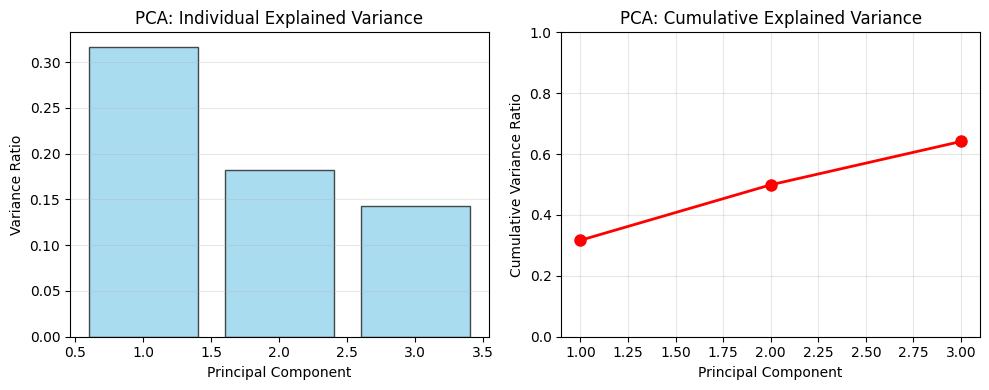

✅ PCA captures 64.1% of macro factor variance with 3 components


In [6]:
# Visualize explained variance
plt.figure(figsize=(10, 4))

# Subplot 1: Individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(1, n_components + 1), explained_var, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('PCA: Individual Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Cumulative explained variance  
plt.subplot(1, 2, 2)
plt.plot(range(1, n_components + 1), cumulative_var, marker='o', linewidth=2, markersize=8, color='red')
plt.title('PCA: Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Ratio')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"✅ PCA captures {cumulative_var[-1]:.1%} of macro factor variance with {n_components} components")

## 📈 Factor Regression Analysis

Fit linear regression models for each EM equity index using the principal components as explanatory variables.

In [7]:
# Fit linear regression for each EM index against principal components
betas = {}       # Store factor loadings (sensitivities)
r2_scores = {}   # Store model fit statistics

print(f"🔄 Fitting {len(Y.columns)} regression models...\n")

for col in Y.columns:
    # Fit regression: EM_return = α + β₁×PC1 + β₂×PC2 + β₃×PC3 + ε
    model = LinearRegression().fit(X_pca, Y[col])
    
    # Store results
    betas[col] = model.coef_
    r2_scores[col] = model.score(X_pca, Y[col])
    
    print(f"✅ {col}:")
    print(f"   • R² Score: {r2_scores[col]:.3f}")
    print(f"   • Factor Loadings: [{betas[col][0]:.3f}, {betas[col][1]:.3f}, {betas[col][2]:.3f}]")

# Create DataFrame for factor loadings (betas)
beta_df = pd.DataFrame(betas, index=['PC1', 'PC2', 'PC3']).T
beta_df.index.name = 'EM Index'

print(f"\n📊 Factor Loadings Matrix:")
print(beta_df.round(3))

🔄 Fitting 9 regression models...

✅ Brazil:
   • R² Score: 0.227
   • Factor Loadings: [0.004, -0.005, -0.000]
✅ India:
   • R² Score: 0.079
   • Factor Loadings: [0.001, -0.001, -0.000]
✅ China:
   • R² Score: 0.092
   • Factor Loadings: [0.002, -0.003, -0.000]
✅ SouthAfrica:
   • R² Score: 0.167
   • Factor Loadings: [0.002, -0.003, -0.000]
✅ Mexico:
   • R² Score: 0.260
   • Factor Loadings: [0.003, -0.004, -0.000]
✅ Indonesia:
   • R² Score: 0.042
   • Factor Loadings: [0.001, -0.001, -0.000]
✅ Taiwan:
   • R² Score: 0.036
   • Factor Loadings: [0.001, -0.001, -0.000]
✅ Korea:
   • R² Score: 0.059
   • Factor Loadings: [0.001, -0.001, -0.000]
✅ US:
   • R² Score: 0.495
   • Factor Loadings: [0.004, -0.004, -0.000]

📊 Factor Loadings Matrix:
               PC1    PC2  PC3
EM Index                      
Brazil       0.004 -0.005 -0.0
India        0.001 -0.001 -0.0
China        0.002 -0.003 -0.0
SouthAfrica  0.002 -0.003 -0.0
Mexico       0.003 -0.004 -0.0
Indonesia    0.001 -0.001 -0

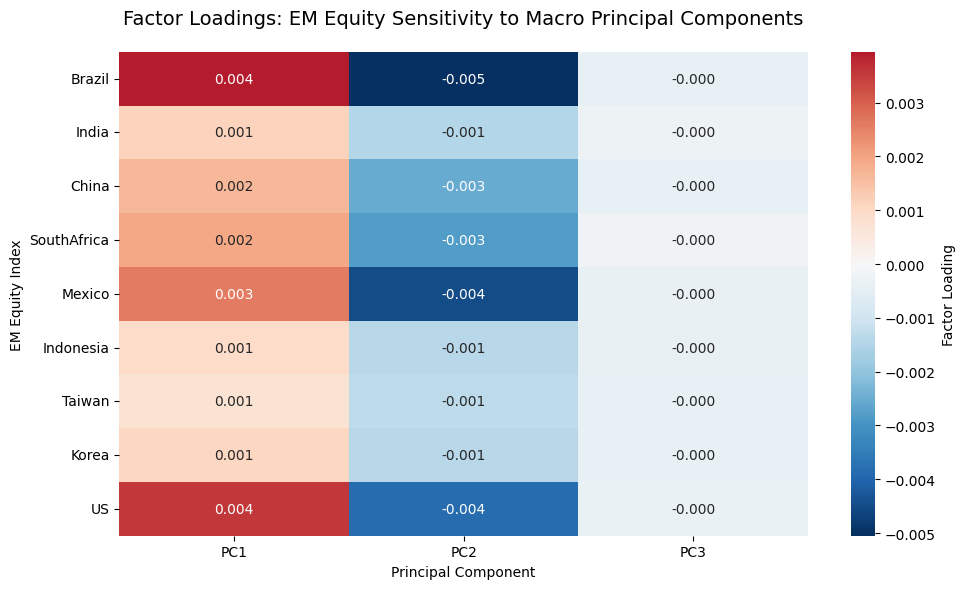

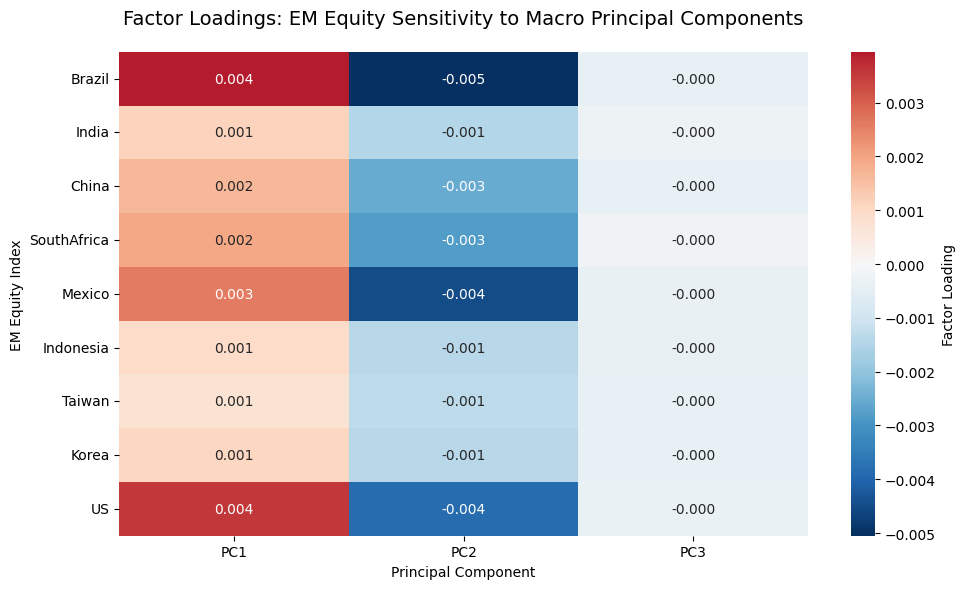

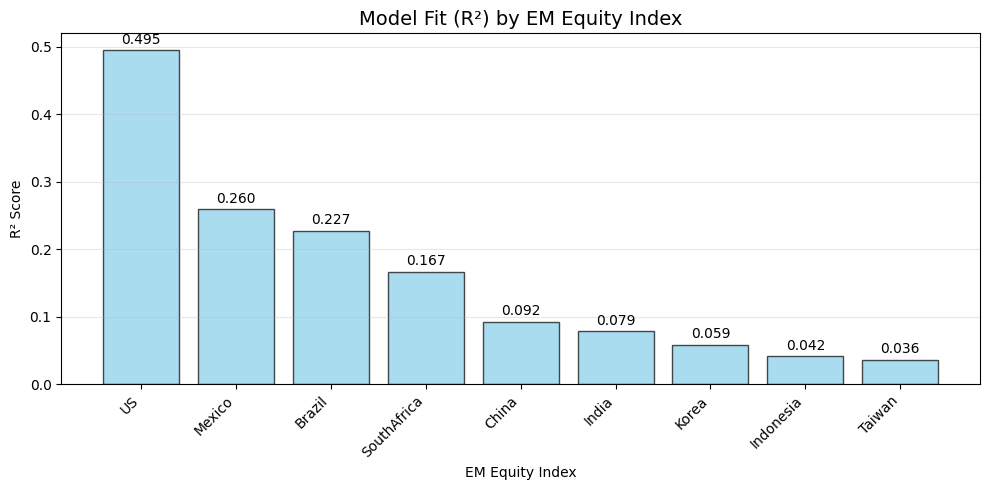


📈 Model Performance Summary:
   • Best fit: US (R² = 0.495)
   • Worst fit: Taiwan (R² = 0.036)
   • Average R²: 0.162


In [8]:
# Visualize factor loadings as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(beta_df, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', cbar_kws={'label': 'Factor Loading'})
plt.title('Factor Loadings: EM Equity Sensitivity to Macro Principal Components', fontsize=14, pad=20)
plt.xlabel('Principal Component')
plt.ylabel('EM Equity Index')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.heatmap(beta_df, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', cbar_kws={'label': 'Factor Loading'})
plt.title('Factor Loadings: EM Equity Sensitivity to Macro Principal Components', fontsize=14, pad=20)
plt.xlabel('Principal Component')
plt.ylabel('EM Equity Index')
plt.tight_layout()
plt.show()

# Create R² scores summary
r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R² Score'])
r2_df = r2_df.sort_values('R² Score', ascending=False)

# Plot R² scores
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(r2_df)), r2_df['R² Score'], color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Model Fit (R²) by EM Equity Index', fontsize=14)
plt.xlabel('EM Equity Index')
plt.ylabel('R² Score')
plt.xticks(range(len(r2_df)), r2_df.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n📈 Model Performance Summary:")
print(f"   • Best fit: {r2_df.index[0]} (R² = {r2_df.iloc[0, 0]:.3f})")
print(f"   • Worst fit: {r2_df.index[-1]} (R² = {r2_df.iloc[-1, 0]:.3f})")
print(f"   • Average R²: {r2_df['R² Score'].mean():.3f}")

## 🎯 Model Validation & Visualization

Generate actual vs. predicted plots for each EM index and save results for the output folder.

## 📅 Yearly Analysis: Factor Sensitivity Evolution

Understanding how factor relationships change over time is crucial for investment strategy. Let's analyze how EM-macro sensitivities evolved across three distinct periods:

### Analysis Periods:
- **2022/2023**: July 2022 - June 2023 (Post-COVID recovery, inflation concerns)
- **2023/2024**: July 2023 - June 2024 (Central bank policy normalization)  
- **2024/2025**: July 2024 - Present (Current market regime)

This analysis will reveal:
- **Structural Changes**: How geopolitical events and policy shifts affected factor relationships
- **Market Evolution**: Whether EM markets became more or less integrated with global factors
- **Regional Divergence**: Which markets showed the most/least stability in factor sensitivity

In [9]:
# Define yearly analysis periods (calendar year approach for better interpretation)
yearly_periods = {
    '2022/2023': ('2022-01-01', '2023-12-31'),
    '2023/2024': ('2023-01-01', '2024-12-31'), 
    '2024/2025': ('2024-01-01', '2025-08-06')
}

# Initialize storage for yearly results
yearly_results = {}
yearly_loadings = {}
yearly_pca_variance = {}

print("📊 Performing Comprehensive Yearly Factor Sensitivity Analysis")
print("="*65)

# Analyze each yearly period
for period_name, (start_date, end_date) in yearly_periods.items():
    print(f"\n🗓️  Analyzing {period_name} Period")
    print(f"   📅 Date Range: {start_date} to {end_date}")
    
    # Filter data for the specific period
    period_mask = (log_returns.index >= start_date) & (log_returns.index <= end_date)
    Y_period = log_returns[em_columns][period_mask]
    X_period = log_returns[macro_columns][period_mask]
    
    if len(Y_period) < 50:  # Skip if insufficient data
        print(f"   ⚠️  Insufficient data ({len(Y_period)} observations) - skipping period")
        continue
    
    print(f"   📈 Trading Days: {len(Y_period)} observations")
    print(f"   📊 Data Quality: {(1 - Y_period.isnull().sum().max() / len(Y_period)) * 100:.1f}% complete")
    
    # Apply PCA to period data
    scaler_period = StandardScaler()
    X_scaled_period = scaler_period.fit_transform(X_period.fillna(method='ffill'))
    
    pca_period = PCA(n_components=3)
    X_pca_period = pca_period.fit_transform(X_scaled_period)
    
    # Store PCA explained variance for this period
    pca_variance = pca_period.explained_variance_ratio_
    yearly_pca_variance[period_name] = pca_variance
    print(f"   🔍 PCA Variance: PC1={pca_variance[0]:.1%}, PC2={pca_variance[1]:.1%}, PC3={pca_variance[2]:.1%} (Total: {sum(pca_variance):.1%})")
    
    # Calculate R² for each EM market in this period
    period_r2 = {}
    period_loadings = {}
    
    print(f"   📈 Factor Model Results:")
    for em_market in em_columns:
        try:
            # Get clean data for this market
            y_market = Y_period[em_market].dropna()
            
            # Align dates between Y and X
            common_dates = y_market.index.intersection(X_period.index)
            if len(common_dates) < 30:
                print(f"      ⚠️  {em_market}: Insufficient aligned data ({len(common_dates)} days)")
                continue
            
            y_aligned = y_market.loc[common_dates]
            X_aligned = X_period.loc[common_dates].fillna(method='ffill')
            
            # Re-standardize and apply PCA for aligned data
            X_scaled_aligned = scaler_period.fit_transform(X_aligned)
            X_pca_aligned = pca_period.fit_transform(X_scaled_aligned)
            
            # Fit regression model for this period
            model_period = LinearRegression()
            model_period.fit(X_pca_aligned, y_aligned)
            
            # Calculate R² score
            r2_period = model_period.score(X_pca_aligned, y_aligned)
            period_r2[em_market] = r2_period
            
            # Store factor loadings
            period_loadings[em_market] = {
                'PC1': model_period.coef_[0],
                'PC2': model_period.coef_[1],
                'PC3': model_period.coef_[2],
                'Intercept': model_period.intercept_,
                'N_observations': len(y_aligned)
            }
            
            print(f"      ✅ {em_market:<20}: R² = {r2_period:.3f} ({len(y_aligned)} days)")
            
        except Exception as e:
            print(f"      ⚠️  {em_market}: Error - {str(e)}")
            period_r2[em_market] = np.nan
    
    # Store results for this period
    yearly_results[period_name] = period_r2
    yearly_loadings[period_name] = period_loadings

print("\n" + "="*65)
print("✅ Yearly Analysis Complete!")

# Create comprehensive summary DataFrame
yearly_r2_df = pd.DataFrame(yearly_results)
yearly_r2_df = yearly_r2_df.round(3)

print(f"\n📋 R² SCORES BY ANNUAL PERIOD:")
print(yearly_r2_df.to_string())

# Calculate summary statistics
print(f"\n📊 SUMMARY STATISTICS:")
period_stats = yearly_r2_df.describe().round(3)
print(period_stats)

# Period-over-period analysis
if len(yearly_r2_df.columns) >= 2:
    print(f"\n📈 FACTOR SENSITIVITY EVOLUTION:")
    
    # Calculate changes between consecutive periods
    for i in range(1, len(yearly_r2_df.columns)):
        current_period = yearly_r2_df.columns[i]
        previous_period = yearly_r2_df.columns[i-1]
        change = yearly_r2_df[current_period] - yearly_r2_df[previous_period]
        
        print(f"\n{previous_period} → {current_period} (Change in R²):")
        for market in change.index:
            if not pd.isna(change[market]):
                if change[market] > 0.05:
                    direction = "📈 LARGE INCREASE"
                elif change[market] > 0:
                    direction = "↗️ Increase"
                elif change[market] < -0.05:
                    direction = "📉 LARGE DECREASE"
                elif change[market] < 0:
                    direction = "↘️ Decrease"
                else:
                    direction = "➡️ Stable"
                
                print(f"   {direction:<15} {market:<20}: {change[market]:+.3f}")

# Market stability analysis across periods
if len(yearly_r2_df.columns) >= 2:
    r2_std = yearly_r2_df.std(axis=1, skipna=True)
    r2_mean = yearly_r2_df.mean(axis=1, skipna=True)
    
    print(f"\n🎯 MARKET STABILITY ANALYSIS:")
    print(f"\nMost Stable Factor Sensitivity (lowest R² volatility):")
    for market in r2_std.nsmallest(3).index:
        print(f"   🟢 {market:<20}: Mean R² = {r2_mean[market]:.3f}, Volatility = {r2_std[market]:.3f}")
    
    print(f"\nMost Variable Factor Sensitivity (highest R² volatility):")
    for market in r2_std.nlargest(3).index:
        print(f"   🔴 {market:<20}: Mean R² = {r2_mean[market]:.3f}, Volatility = {r2_std[market]:.3f}")

# Period characterization based on average R²
period_averages = yearly_r2_df.mean(skipna=True)
print(f"\n🌍 MACRO INTEGRATION BY PERIOD:")
for period, avg_r2 in period_averages.items():
    if avg_r2 > 0.25:
        integration_level = "HIGH macro integration"
        emoji = "🔗"
    elif avg_r2 > 0.15:
        integration_level = "MODERATE macro integration"
        emoji = "🔀"
    else:
        integration_level = "LOW macro integration" 
        emoji = "🔓"
    
    print(f"   {emoji} {period}: {integration_level} (Avg R² = {avg_r2:.3f})")

# Investment implications
print(f"\n💼 INVESTMENT IMPLICATIONS:")
print("="*50)

# Find best/worst markets in latest period
if len(yearly_r2_df.columns) > 0:
    latest_period = yearly_r2_df.columns[-1]
    latest_data = yearly_r2_df[latest_period].dropna()
    
    if len(latest_data) > 0:
        highest_sensitivity = latest_data.idxmax()
        lowest_sensitivity = latest_data.idxmin()
        
        print(f"\n📊 Current Period ({latest_period}) Insights:")
        print(f"   🎯 Highest Macro Sensitivity: {highest_sensitivity} (R² = {latest_data.max():.3f})")
        print(f"      → Best for macro factor strategies and tactical allocation")
        print(f"   🛡️  Lowest Macro Sensitivity:  {lowest_sensitivity} (R² = {latest_data.min():.3f})")
        print(f"      → Best for portfolio diversification and risk reduction")

print(f"\n🔄 DYNAMIC STRATEGY RECOMMENDATIONS:")
print("   • Rebalance factor exposures quarterly based on regime changes")
print("   • Use high-sensitivity markets for macro momentum strategies")
print("   • Use low-sensitivity markets for diversification during volatile periods")
print("   • Monitor trend persistence to distinguish temporary vs permanent shifts")
print("   • Implement dynamic hedging based on current period factor loadings")

📊 Performing Comprehensive Yearly Factor Sensitivity Analysis

🗓️  Analyzing 2022/2023 Period
   📅 Date Range: 2022-01-01 to 2023-12-31
   📈 Trading Days: 727 observations
   📊 Data Quality: 100.0% complete
   🔍 PCA Variance: PC1=28.6%, PC2=24.3%, PC3=15.0% (Total: 67.9%)
   📈 Factor Model Results:
      ✅ Brazil              : R² = 0.190 (727 days)
      ✅ India               : R² = 0.073 (727 days)
      ✅ China               : R² = 0.083 (727 days)
      ✅ SouthAfrica         : R² = 0.176 (727 days)
      ✅ Mexico              : R² = 0.323 (727 days)
      ✅ Indonesia           : R² = 0.026 (727 days)
      ✅ Taiwan              : R² = 0.045 (727 days)
      ✅ Korea               : R² = 0.045 (727 days)
      ✅ US                  : R² = 0.583 (727 days)

🗓️  Analyzing 2023/2024 Period
   📅 Date Range: 2023-01-01 to 2024-12-31
   📈 Trading Days: 728 observations
   📊 Data Quality: 100.0% complete
   🔍 PCA Variance: PC1=33.3%, PC2=21.2%, PC3=14.6% (Total: 69.0%)
   📈 Factor Model Res

/var/folders/mv/dxymwk8x2kqctngjslq2tbdw0000gn/T/ipykernel_25047/3639142241.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_scaled_period = scaler_period.fit_transform(X_period.fillna(method='ffill'))
/var/folders/mv/dxymwk8x2kqctngjslq2tbdw0000gn/T/ipykernel_25047/3639142241.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_aligned = X_period.loc[common_dates].fillna(method='ffill')
/var/folders/mv/dxymwk8x2kqctngjslq2tbdw0000gn/T/ipykernel_25047/3639142241.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_aligned = X_period.loc[common_dates].fillna(method='ffill')
/var/folders/mv/dxymwk8x2kqctngjslq2tbdw0000gn/T/ipykernel_25047/3639142241.py:62: FutureWarning: DataFrame.fillna with 'method' is de

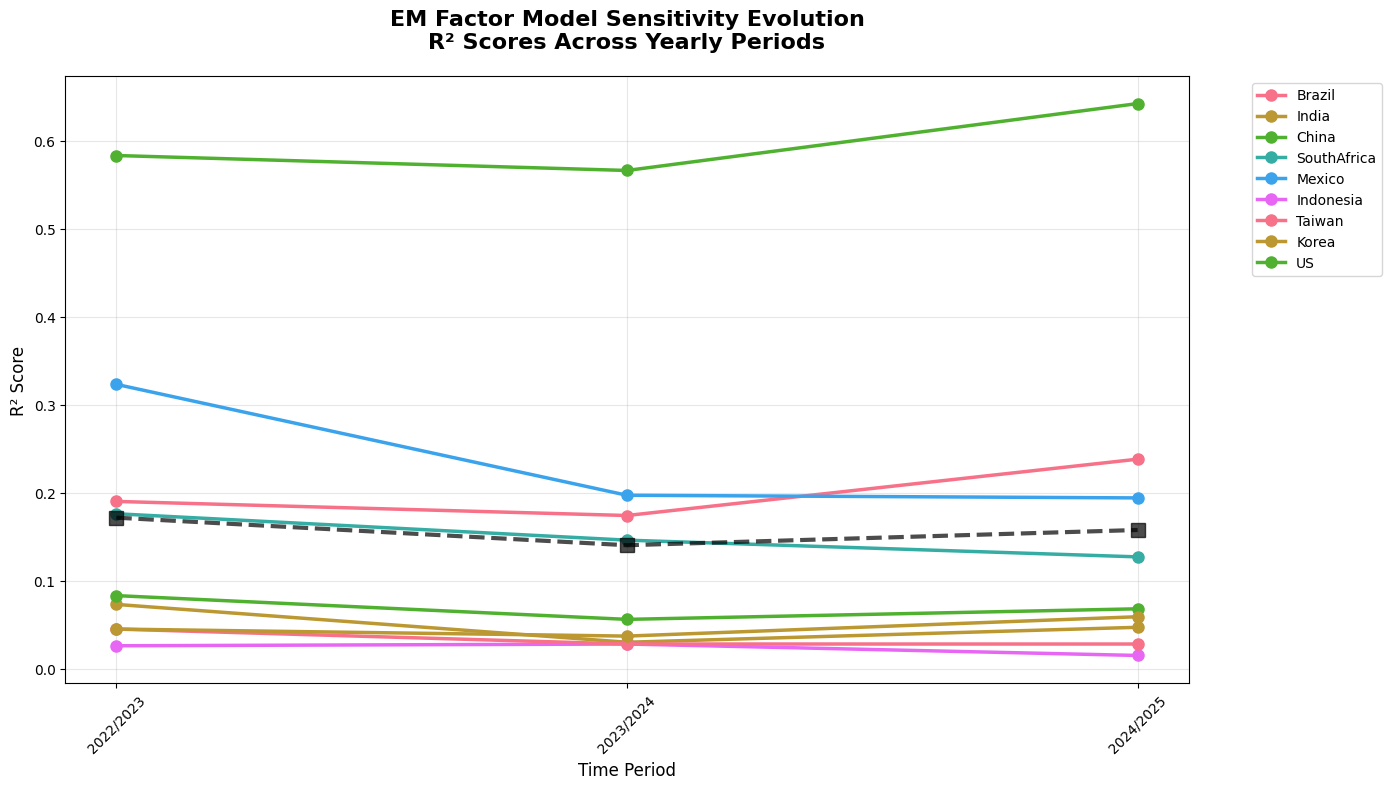

💾 Yearly evolution plot saved to: ../output/plots/yearly_r2_evolution.png


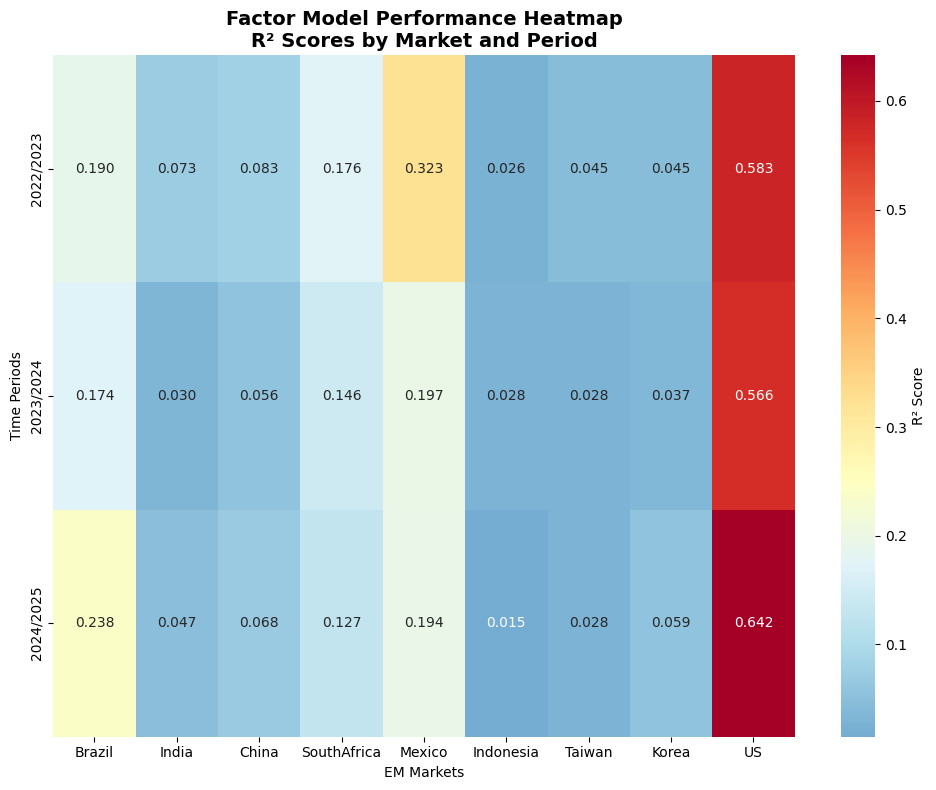

💾 Yearly R² heatmap saved to: ../output/plots/yearly_r2_heatmap.png

📊 Yearly Analysis Summary:
Average R² across all periods: 0.156
Range of R² values: 0.015 - 0.642

📈 Market Integration Trends:
   📈 Increasing Integration: US
   📉 Decreasing Integration: Mexico
   ➡️  Stable Integration: Brazil, India, China, SouthAfrica, Indonesia, Taiwan, Korea

🎯 Yearly factor sensitivity analysis complete!
Results show how EM-macro relationships evolved across different market regimes.


In [10]:
# Create visualization of yearly R² evolution
if len(yearly_r2_df.columns) >= 2:
    plt.figure(figsize=(14, 8))
    
    # Plot R² evolution for each market
    for market in yearly_r2_df.index:
        plt.plot(yearly_r2_df.columns, yearly_r2_df.loc[market], 
                marker='o', linewidth=2.5, markersize=8, label=market)
    
    plt.title('EM Factor Model Sensitivity Evolution\nR² Scores Across Yearly Periods', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Time Period', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add average line
    avg_r2 = yearly_r2_df.mean()
    plt.plot(yearly_r2_df.columns, avg_r2, 
             color='black', linestyle='--', linewidth=3, 
             marker='s', markersize=10, label='Average', alpha=0.7)
    
    plt.tight_layout()
    
    # Save plot
    plt.savefig('../output/plots/yearly_r2_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("💾 Yearly evolution plot saved to: ../output/plots/yearly_r2_evolution.png")

# Create heatmap of yearly R² scores
plt.figure(figsize=(10, 8))
sns.heatmap(yearly_r2_df.T, annot=True, cmap='RdYlBu_r', center=0.25,
            fmt='.3f', cbar_kws={'label': 'R² Score'})
plt.title('Factor Model Performance Heatmap\nR² Scores by Market and Period', 
          fontsize=14, fontweight='bold')
plt.xlabel('EM Markets')
plt.ylabel('Time Periods')
plt.tight_layout()

# Save heatmap
plt.savefig('../output/plots/yearly_r2_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Yearly R² heatmap saved to: ../output/plots/yearly_r2_heatmap.png")

# Summary statistics
print(f"\n📊 Yearly Analysis Summary:")
print(f"Average R² across all periods: {yearly_r2_df.stack().mean():.3f}")
print(f"Range of R² values: {yearly_r2_df.stack().min():.3f} - {yearly_r2_df.stack().max():.3f}")

if len(yearly_r2_df.columns) >= 2:
    # Check for trending patterns
    print(f"\n📈 Market Integration Trends:")
    latest_period = yearly_r2_df.columns[-1]
    first_period = yearly_r2_df.columns[0]
    
    overall_change = yearly_r2_df[latest_period] - yearly_r2_df[first_period]
    
    increasing_markets = overall_change[overall_change > 0.05].index.tolist()
    decreasing_markets = overall_change[overall_change < -0.05].index.tolist()
    stable_markets = overall_change[abs(overall_change) <= 0.05].index.tolist()
    
    if increasing_markets:
        print(f"   📈 Increasing Integration: {', '.join(increasing_markets)}")
    if decreasing_markets:
        print(f"   📉 Decreasing Integration: {', '.join(decreasing_markets)}")
    if stable_markets:
        print(f"   ➡️  Stable Integration: {', '.join(stable_markets)}")

print(f"\n🎯 Yearly factor sensitivity analysis complete!")
print(f"Results show how EM-macro relationships evolved across different market regimes.")

📊 Generating actual vs. predicted plots for 9 EM indices...



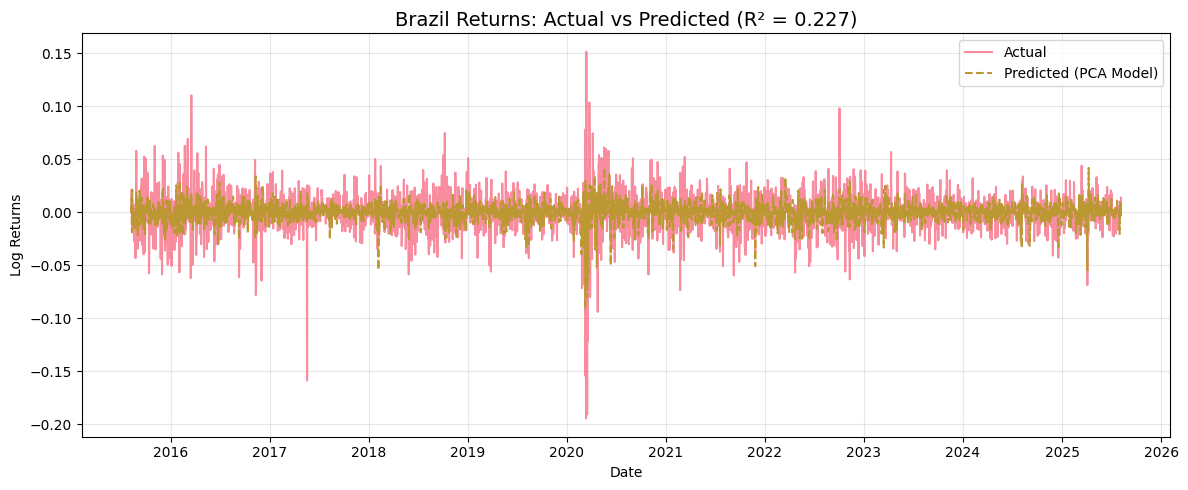

✅ Brazil: R² = 0.227, Plot saved to Brazil.png


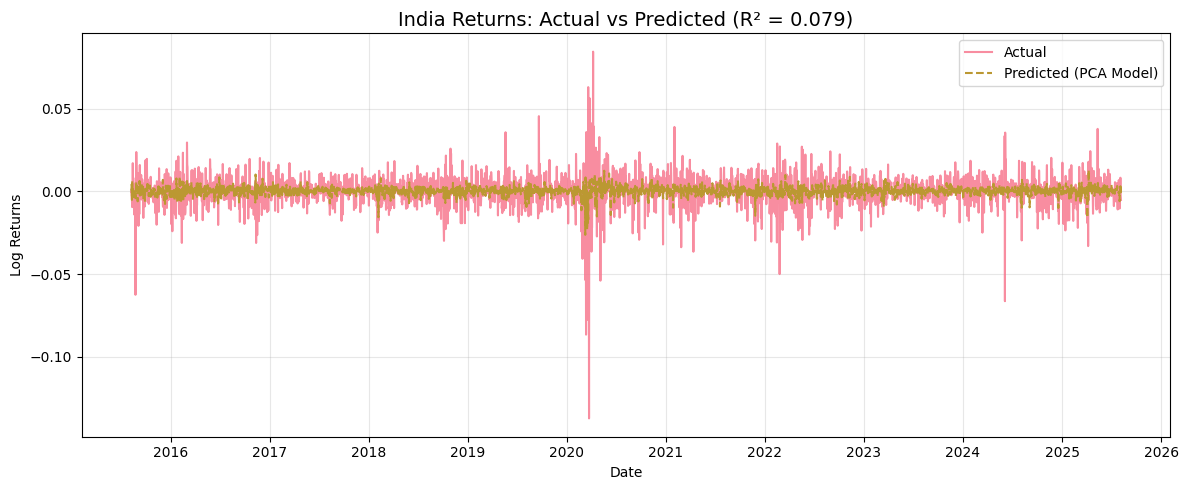

✅ India: R² = 0.079, Plot saved to India.png


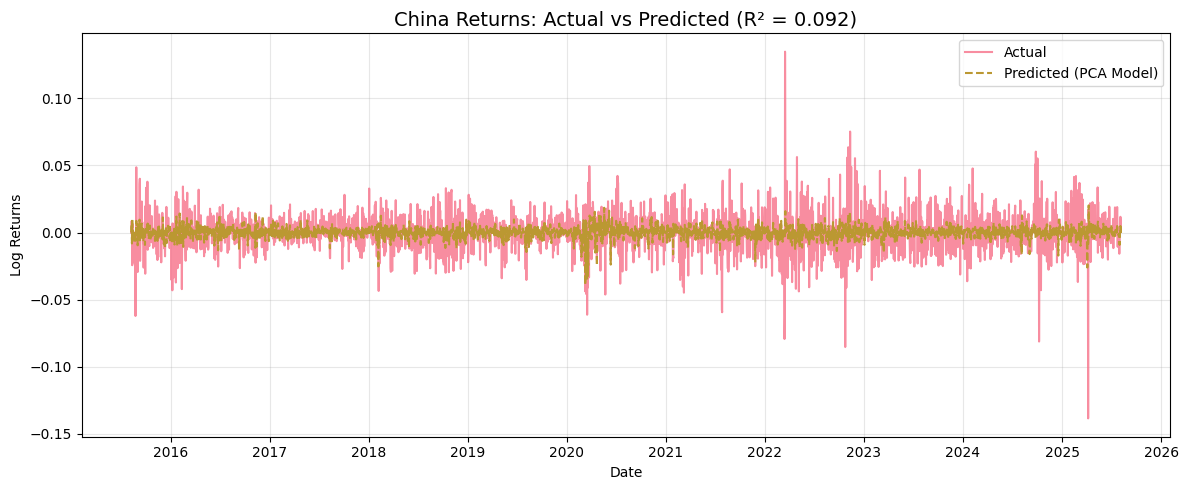

✅ China: R² = 0.092, Plot saved to China.png


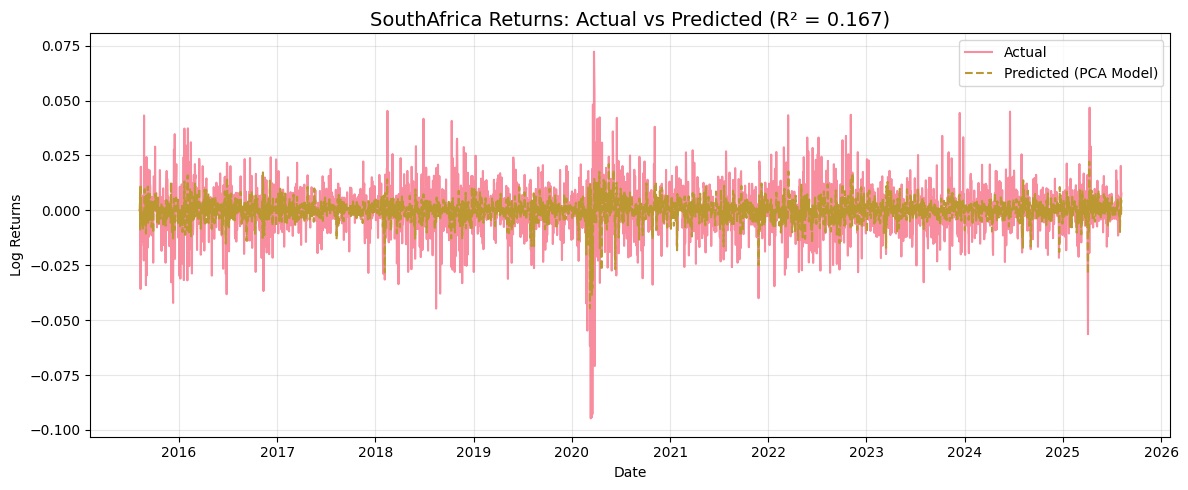

✅ SouthAfrica: R² = 0.167, Plot saved to SouthAfrica.png


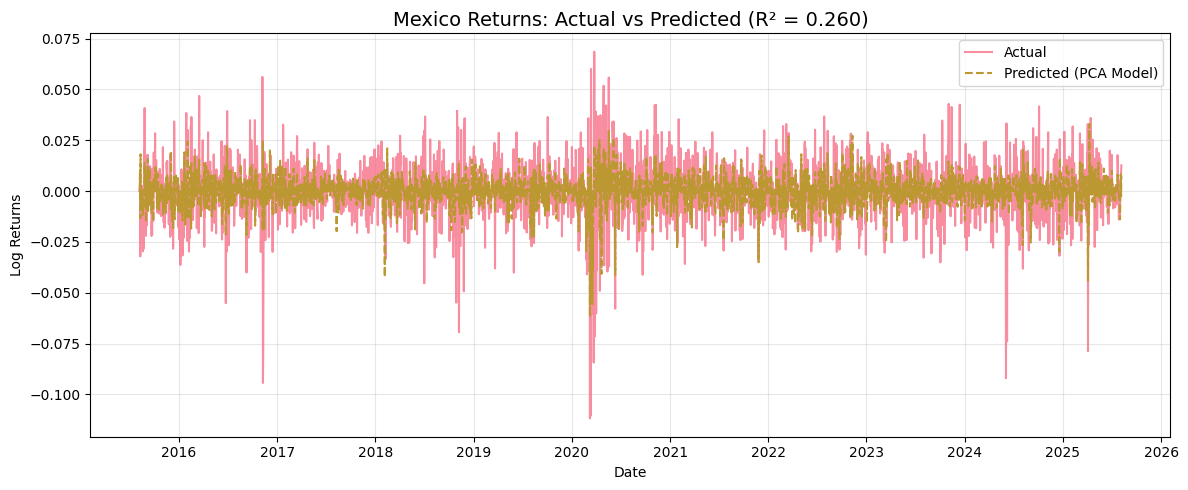

✅ Mexico: R² = 0.260, Plot saved to Mexico.png


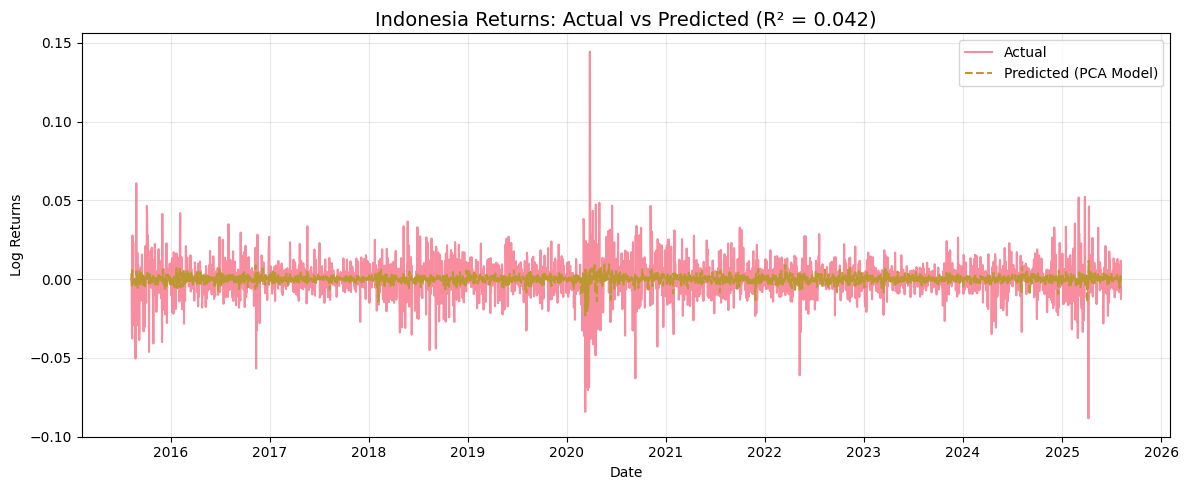

✅ Indonesia: R² = 0.042, Plot saved to Indonesia.png


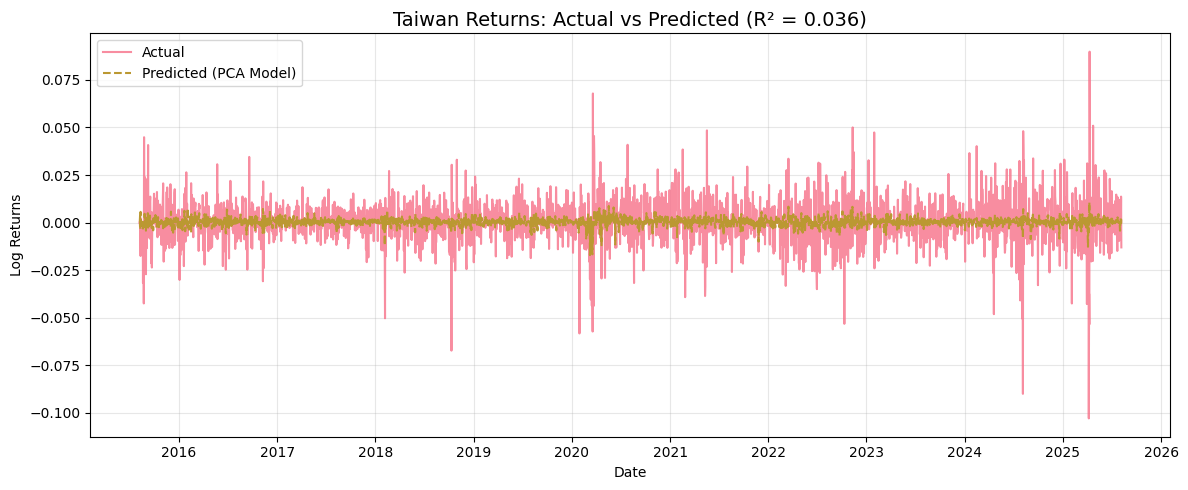

✅ Taiwan: R² = 0.036, Plot saved to Taiwan.png


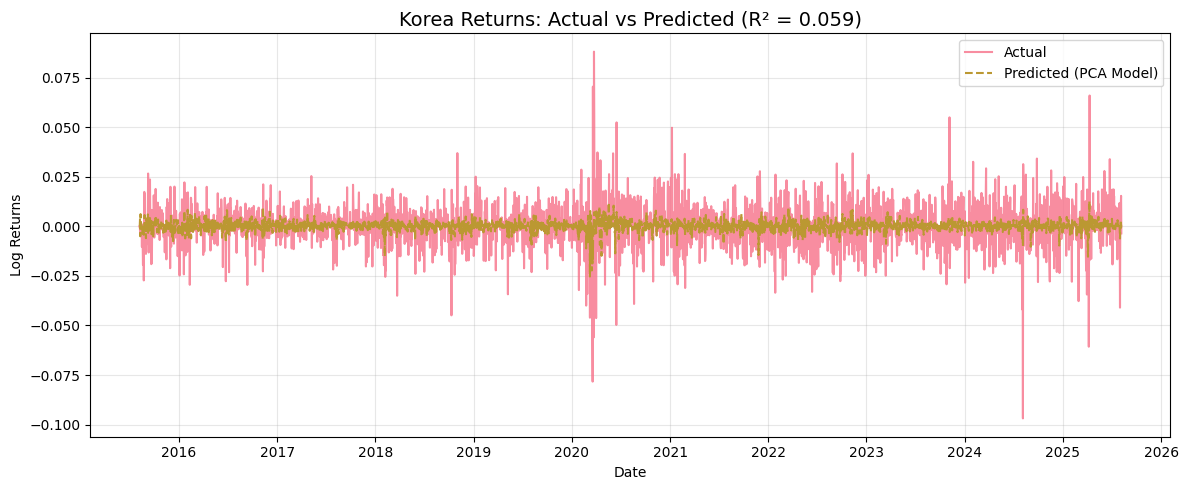

✅ Korea: R² = 0.059, Plot saved to Korea.png


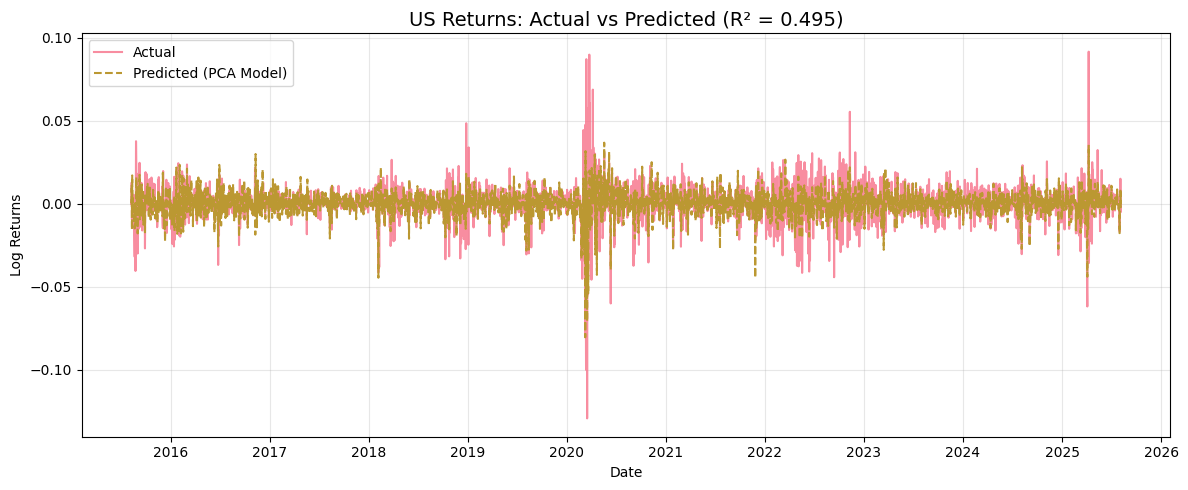

✅ US: R² = 0.495, Plot saved to US.png

💾 All plots saved to: ../output/plots
🎯 Analysis complete! Factor modeling successfully applied to 9 EM indices.


In [11]:
# Create output directory for plots
plot_dir = '../output/plots'
os.makedirs(plot_dir, exist_ok=True)

# Generate actual vs predicted plots for all EM indices
print(f"📊 Generating actual vs. predicted plots for {len(Y.columns)} EM indices...\n")

for col in Y.columns:
    # Fit model and generate predictions
    model = LinearRegression().fit(X_pca, Y[col])
    Y_pred = model.predict(X_pca)
    r2 = model.score(X_pca, Y[col])
    
    # Create plot
    plt.figure(figsize=(12, 5))
    
    plt.plot(Y.index, Y[col], label='Actual', linewidth=1.5, alpha=0.8)
    plt.plot(Y.index, Y_pred, label='Predicted (PCA Model)', linestyle='--', linewidth=1.5)
    
    plt.title(f'{col} Returns: Actual vs Predicted (R² = {r2:.3f})', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    filename = col.replace(" ", "_").replace("/", "_") + '.png'
    plot_path = os.path.join(plot_dir, filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ {col}: R² = {r2:.3f}, Plot saved to {filename}")

print(f"\n💾 All plots saved to: {plot_dir}")
print(f"🎯 Analysis complete! Factor modeling successfully applied to {len(Y.columns)} EM indices.")